In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad

# S(Q, $\omega$) generation
Costruiamo qui un modello di S(Q, $\omega$) con cui testare l'operazione monte carlo. Questo è un'estrapolazione de degli articoli e vale per il benzene deuterato.

## Costruzione della S(Q, $\omega$)

In [2]:
### S(Q,E) ###
# S(Q)
rawSqd6ext = np.loadtxt('./data_Sq/Sqw_generation/Sq_d-benzeneEXT_paper.csv', delimiter=',')
rawSqd6ext[:,1] -= 2

b = {}
b['D'] = 6.671
b['C'] = 6.6460
c = {}
c['D'] = 6/(6+6)
c['C'] = 6/(6+6)

Sincd6 = (4.04**2/2 + 0/2) * 1e-2

C = 2*c['D']*c['C']*b['D']*b['C'] + 2*c['D']**2*b['D']**2 + 2*c['C']**2*b['C']**2
C = C/(1e2)
Scohd6 = lambda x: np.interp(x, rawSqd6ext[:,0], rawSqd6ext[:,1]+ C)

# Debey-Waller lambda
sigma_DBW = 6
DBW = lambda x: np.exp(-(x)**2/(2*sigma_DBW**2))

# Gamma lambda
def GammaEl(Q):
    if Q < 3: return 1.5*Q
    else: return -4.3 + 3*Q
GammaEl = np.vectorize(GammaEl)

# Inelastic Gamma lambda
GammaInel = lambda Q: 8.54084 * Q

# Population factor lambda
def d_balance_single(E, T):
    kB = 8.617333262e-2 # meV/K
    if E==0:
        return 1
    else:
        return E/(kB*T) * (1/(np.exp(E / (kB*T)) - 1) + 1)
d_balance = np.vectorize(d_balance_single)

Sel = lambda Q, omega: 1/np.pi * (GammaEl(Q) / (omega**2 + GammaEl(Q)**2))

Sinel = lambda Q, E: 1/(3*np.pi*GammaInel(Q)) * (np.arctan(E+3/2*GammaInel(Q)) - np.arctan(E-3/2*GammaInel(Q)))

In [3]:
def S(Q, omega):
    T = 300
    omega_min = -1000
    omega_max = 1000

    S_tonorm = lambda omega: (DBW(Q) * Sel(Q, omega) + (1-DBW(Q)) * Sinel(Q, omega)) * d_balance(omega, 300)

    norm = quad(S_tonorm, omega_min, omega_max)[0]

    return S_tonorm(omega) / norm * (Scohd6(Q) + Sincd6)

(-2.0, 2.0)

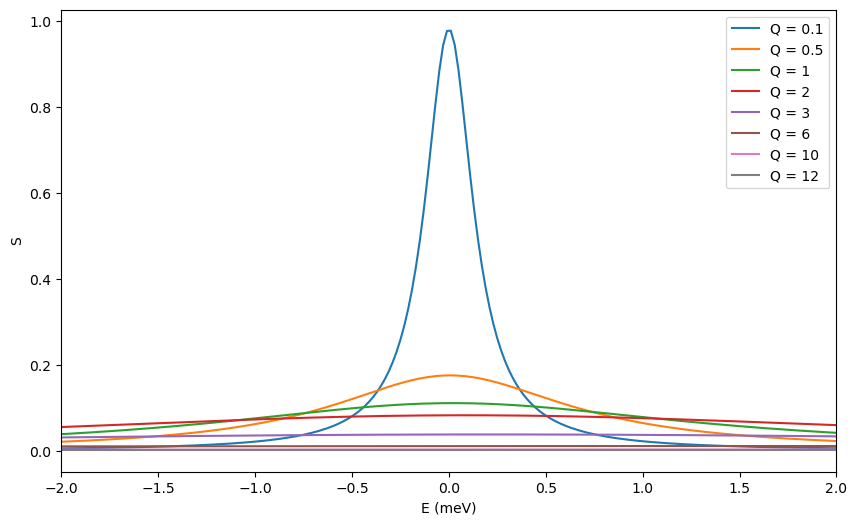

In [4]:
plt.figure(figsize=(10,6))

omega = np.linspace(-100, 100, 10000)
for q in [.1, .5, 1, 2, 3, 6, 10, 12]:
    plt.plot(omega, S(q, omega), label='Q = '+str(q))

plt.xlabel('E (meV)')
plt.ylabel('S')
plt.legend()
#plt.yscale('log')
plt.xlim(-2,2)

Text(0, 0.5, 'Integrated S(Q,E) (barns/str/atom)')

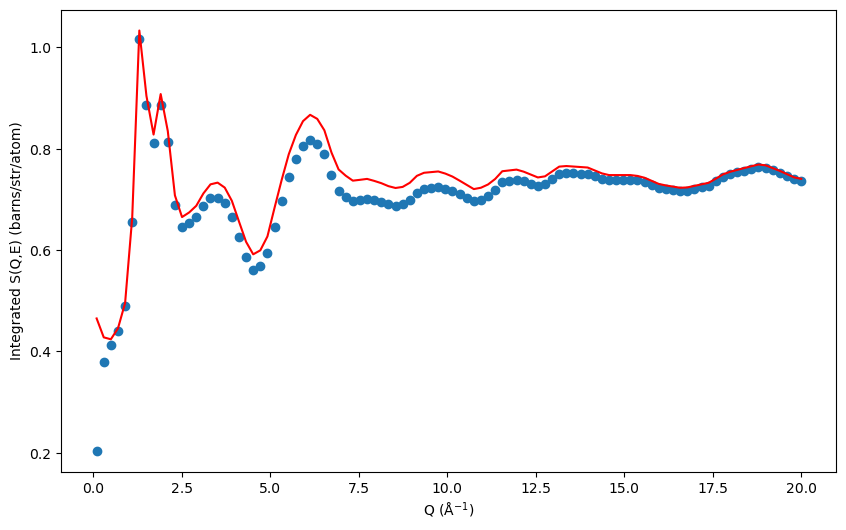

In [5]:
omega = np.linspace(-500, 500, 1000)
q = np.linspace(0.1, 20, 100)

Sq = [S(qi, omega).sum() for qi in q]

# plot of the integral of the above
plt.figure(figsize=(10,6))

plt.scatter(q, Sq)
plt.plot(q, (Scohd6(q) + Sincd6), c='r')
plt.xlabel('Q (Å$^{-1}$)')
plt.ylabel('Integrated S(Q,E) (barns/str/atom)')

## Salvataggio della Mesh su S(Q, $\omega$)

In [7]:
Qmin, Qmax, dQ = .01, 14, .01
omega_min, omega_max, domega = -100, 100, .1

Q_vec = np.arange(Qmin, Qmax, dQ)
omega_vec = np.arange(omega_min, omega_max, domega)


S_mesh = np.array([S(Qmin, omega_vec)])
for q in Q_vec[1:]:
    S_mesh = np.vstack((S_mesh, S(q, omega_vec)))

S_mesh_len = S_mesh.shape[0]*S_mesh.shape[1]

################################################
print('S_mesh dimension:', S_mesh.nbytes/1e6, 'MB')
print('Q_vec:', Q_vec[:10])
print('omega_vec:', omega_vec[:10])

#################################################

# save
np.save('./data_Sq/Sqw_d-glycerol/S_mesh.npy', S_mesh)
np.save('./data_Sq/Sqw_d-glycerol/Q_vec.npy', Q_vec)
np.save('./data_Sq/Sqw_d-glycerol/omega_vec.npy', omega_vec)

S_mesh dimension: 22.384 MB
Q_vec: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
omega_vec: [-100.   -99.9  -99.8  -99.7  -99.6  -99.5  -99.4  -99.3  -99.2  -99.1]
